# 0 - Instalation of modules

In [ ]:
#Run this cell to have the progress bar
!pip install tqdm
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

# 1 - Importing modules

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# 2 - Get all files needed

In [2]:
data_folder = "../../Dataset/Movie/"

In [15]:
rating = pd.read_csv(f"{data_folder}ratings.csv").drop(["timestamp"], axis=1)
movie = pd.read_csv(f"{data_folder}movies.csv")

data = pd.merge(movie, rating, on="movieId")

# 3 - Transforming data

In [16]:
#Séparation en ligne du dataframe en petits dataframe
N = 1000
data_list = []
L = data.shape[0]

for i in range(1,N+1):
    debut = int((i-1)*L/N)
    fin = int(i*L/N)
    data_list.append(data.iloc[debut:fin, :])

In [17]:
#pivot table de chaque petits dataframe
pv_list = []
N = len(data_list)

i = 0
for d in tqdm(data_list):
    pv_list.append(d.pivot_table(index="userId", columns="title", values="rating", dropna=False))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
#Réunir tous les pivots tables selon le film
titles = data.title.unique()
dico = {title : [] for title in titles}

for pv in pv_list:
    for title in pv:
        dico[title].append(pv[title])

In [19]:
#Concatener tous les pivots tables selon leur film et on les gardes uniquement si ils ont pas trop d'éléments manquant.
all_df = []
keep_title = []
thresh = 0.3

i = 0
for title in tqdm(titles):
    tmp = pd.concat(dico[title], axis=0)
    if not (np.sum(tmp.isna(), axis=0) > tmp.shape[0]*thresh):
        all_df.append(tmp)
        keep_title.append(title)

  0%|          | 0/58958 [00:00<?, ?it/s]

In [ ]:
#On met tous les données dans un seul dataframe
userId_title_df = pd.DataFrame(index=np.sort(data.userId.unique()), columns=keep_title)

for df in tqdm(all_df):
    index = df.index
    values = df.values
    title = df.name

    for i in range(len(index)):
        userId_title_df.iloc[index[i]-1][title] = values[i]

userId_title_df.to_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [15]:
#Si la dataframe a déjà été exporté, on peut le récupérer localement
if not ("userId_title_df" in locals()):
    userId_title_df = pd.read_csv(f"{data_folder}userId_title_df.csv", sep=";")

In [16]:
userId_title_df = userId_title_df.dropna(axis=0, thresh=50)

# 4 - Colaborative filtering
## 4.1 - Find cluster
### 4.1.1 - Cosine distance

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

In [17]:
def standardize(row):
    return row - np.mean(row)

userId_title_std = userId_title_df.apply(standardize, axis=1).fillna(0)
userId_title_std.shape

In [19]:
cos = cosine_similarity(userId_title_std)

L = len(cos)
cluster = {}

for i in tqdm(range(L)):
    cluster[i] = {"+" : [], "-" : []}
    for j in range(i+1, L):
        if (cos[i,j] >= 0.9):
            cluster[i]["+"].append(j)
        elif (cos[i,j] <= -0.9):
            cluster[i]["-"].append(j)

  0%|          | 0/16893 [00:00<?, ?it/s]

In [112]:
def guess_rate_cluster(user, title):
    if (len(cluster[user]["+"]) == 0):
        return 2.5
    else:
        rate = 0
        coeff = 0
        for u in cluster[user]["+"]:
            if not (pd.isnull(userId_title_df.iloc[u][title])):
                rate += cos[user, u]*userId_title_df.iloc[u][title]
                coeff += cos[user, u]

        if (coeff == 0):
            return 2.5
        else:   
            return rate/coeff

In [114]:
def guess_rate_all(user, title):
    L = len(cos)
    rate = 0
    coef = 0

    for i in range(L):
        if (i != user) and not (pd.isnull(userId_title_df.iloc[i][title])):
            rate += cos[user, i]*userId_title_df.iloc[i][title]
            coef += cos[user, i]

    if (coef == 0):
            return 2.5
    else:   
        return rate/coef

In [116]:
userId_title_df

,Unnamed: 0,Toy Story (1995),"American President, The (1995)",Sense and Sensibility (1995),Ace Ventura: When Nature Calls (1995),Get Shorty (1995),Seven (a.k.a. Se7en) (1995),"Usual Suspects, The (1995)",Die Hard: With a Vengeance (1995),Judge Dredd (1995),...,Kick-Ass (2010),Iron Man 2 (2010),Inception (2010),"King's Speech, The (2010)",Intouchables (2011),Gravity (2013),Interstellar (2014),Whiplash (2014),Star Wars: Episode VII - The Force Awakens (2015),Arrival (2016)
2,3,4.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,...,4.0,4.0,5.0,4.0,NaN,4.0,4.0,5.0,3.0,4.0
11,12,NaN,NaN,NaN,NaN,2.0,NaN,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,13,4.0,NaN,NaN,3.5,NaN,4.0,NaN,NaN,2.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,18,3.0,4.0,3.0,4.0,NaN,4.0,4.0,3.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.5,NaN,3.5,3.5,3.5,2.5,4.0,5.0,4.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162515,162516,4.5,4.0,1.5,1.5,3.5,4.0,5.0,3.0,2.5,...,4.0,3.5,4.0,4.0,4.0,3.5,4.5,4.0,4.0,4.5
162518,162519,5.0,NaN,NaN,NaN,4.0,4.0,5.0,5.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162520,162521,4.0,NaN,NaN,NaN,NaN,3.5,4.5,NaN,1.5,...,4.5,3.5,4.0,NaN,4.5,3.0,4.5,NaN,NaN,NaN
162532,162533,4.5,NaN,NaN,4.0,NaN,3.5,4.5,3.5,NaN,...,2.5,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
import matplotlib.pyplot as plt

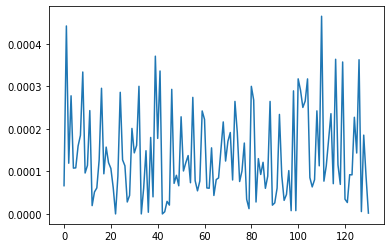

In [121]:
user = 11
titles = userId_title_df.columns[1:]
delta = []

for title in titles:
    delta.append(np.abs(guess_rate_all(user, title) - guess_rate_cluster(user, title)))

plt.plot(delta)